In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
data_filename = 'data/btsv01.txt'
rois = pd.read_csv(data_filename, delim_whitespace=True)
labels_train_filename = 'data/training_fluid_intelligenceV1.csv'
labels_val_filename = 'data/validation_fluid_intelligenceV1.csv'
labels_train = pd.read_csv(labels_train_filename, sep=',')
labels_val = pd.read_csv(labels_val_filename, sep=',')
print("Dataset shape: {}".format(rois.shape))
print("Labels train shape: {}".format(labels_train.shape))
print("Labels val shape: {}".format(labels_val.shape))

Dataset shape: (7803, 131)
Labels train shape: (3739, 2)
Labels val shape: (415, 2)


/Users/admin/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,2,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
columns_description = rois.iloc[0]
#delete the row with description of the columns from data
rois_clean = rois.drop(rois.index[[0]])

In [4]:
print("Number of rows: {}".format(rois_clean.shape[0]))
print("Number of columns: {}".format(rois_clean.shape[1]))

Number of rows: 7802
Number of columns: 131


Here, we will explore the the types of columns to see whether we can skip anything and to get some overview of the data. 
- btsv01_id- all unique values (1 per row) - don't tell us anything; they are descriptive 
- interview_date - the date when the interview was performed - also useless 
- collection_id / dataset_id - identification of the collection/dataset - useless
- collection_title - useless

In general, we have one row per participant.

In [5]:
len(set(labels_train['subject']).intersection(set(rois_clean['subjectkey'])))

3739

Now, we found that our labels with residual fluid intelligence scores are a subset of values in a column 'subjectkey'.
We are constructing a training set, therefore in the training set we will only consider those entries that also have labels. <br>
Furthermore, we are eliminating the following columns: 
- btsv01_id
- interview_date
- collection_id
- dataset_id
- collection_title
- src_subject_id (which is the repetition of subjectkey, but with lowercase letters (for some mysterious reason))

In [6]:
rois_clean = rois_clean.drop(['btsv01_id', 'interview_date', 'collection_id', \
                              'dataset_id', 'collection_title', 'src_subject_id'], axis=1)

In [7]:
#now we are changing the string values of gender to number
gender_to_int = {
    'M': 0,
    'F': 1
}

rois_clean['gender'] = rois_clean['gender'].apply(lambda x: gender_to_int[x])

In [8]:
rois_clean = pd.get_dummies(rois_clean, columns=['gender'])

In [9]:
train_data = rois_clean[rois_clean['subjectkey'].isin(labels_train['subject'])]
val_data = rois_clean[rois_clean['subjectkey'].isin(labels_val['subject'])]

In [10]:
train_data_labels = pd.merge(train_data, labels_train, left_on='subjectkey', right_on='subject').drop(['subject'], axis=1)
val_data_labels = pd.merge(val_data, labels_val, left_on='subjectkey', right_on='subject').drop(['subject'], axis=1)

In [11]:
train_data_labels.shape

(3739, 127)

In [12]:
#here we will construct a matrix only with data - without labels
#the first column is identification - it is a string and we want to delete it. Other columns are identified as string,
#but we want to convert it to floats and to the matrix
train_data_matrix = train_data_labels.values[:, 1:-1].astype(np.float)
val_data_matrix = val_data_labels.values[:, 1:-1].astype(np.float)
print(train_data_matrix.shape)

(3739, 125)


In [13]:
#now for the final form - train_data/val_data will be our matrices; train_labels, val_labels will be our residuals

train_data = train_data_matrix[:,:-2]
val_data = val_data_matrix[:,:-2]

train_labels = train_data_labels['residual_fluid_intelligence_score'].astype(np.float)
val_labels = val_data_labels['residual_fluid_intelligence_score'].astype(np.float)

dataset_columns = train_data_labels.columns 
#important: the last two columns are now binarized wrt to genders

In [14]:
print(train_data.shape)

(3739, 123)


### Distribution of residual values (what are our labels?)

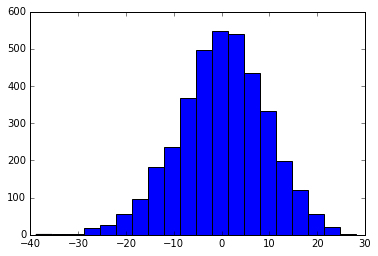

In [15]:
plt.hist(train_labels, bins=20)
plt.show()

### PCA

In [16]:
#first normalize with respect to column
def normalize_data(data: np.array, standardize=True):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    if not standardize:
        return data-means
    return (data-means)/stds


In [17]:
train_norm_data = normalize_data(train_data)
val_norm_data = normalize_data(val_data)

In [18]:
from sklearn.decomposition import PCA

In [19]:
n_components = [2,3,4,5,6,7,8,9,10]
for n in n_components:
    curr_pca = PCA(n_components=n)
    curr_pca.fit_transform(train_norm_data)
    print("For {} components, the explained variance by them is : {:.3f}".format(n, np.sum(curr_pca.explained_variance_ratio_)))

print("*"*10)
explained_variance = [0.8, 0.85, 0.9, 0.95]
for target_variance in explained_variance:
    curr_pca = PCA(n_components=target_variance)
    curr_pca.fit_transform(train_norm_data)
    print("The {} variance ratio is explained by {} components ".format(target_variance, np.sum(curr_pca.n_components_)))


For 2 components, the explained variance by them is : 0.152
For 3 components, the explained variance by them is : 0.191
For 4 components, the explained variance by them is : 0.225
For 5 components, the explained variance by them is : 0.254
For 6 components, the explained variance by them is : 0.281
For 7 components, the explained variance by them is : 0.305
For 8 components, the explained variance by them is : 0.327
For 9 components, the explained variance by them is : 0.347
For 10 components, the explained variance by them is : 0.365
**********
The 0.8 variance ratio is explained by 57 components 
The 0.85 variance ratio is explained by 66 components 
The 0.9 variance ratio is explained by 78 components 
The 0.95 variance ratio is explained by 92 components 


### Covariance matrix of features

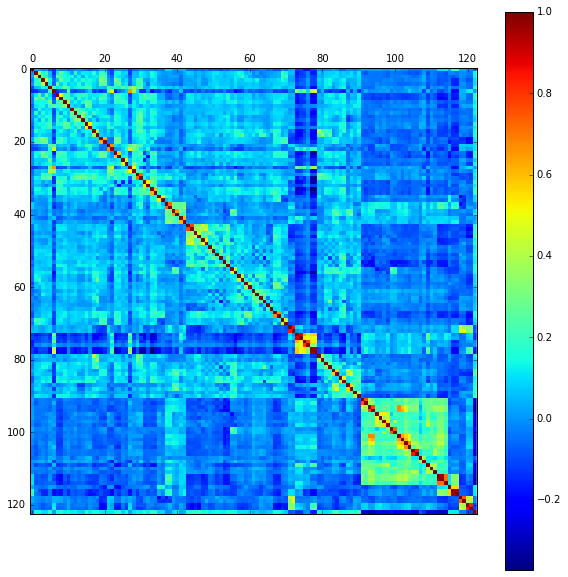

In [20]:
def compute_covariance(matrix):
    return matrix.T.dot(matrix)/matrix.shape[0]

cov_matrix = compute_covariance(train_norm_data)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(cov_matrix, interpolation='none')
fig.colorbar(im, ticks=[-1,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
plt.show()

In [21]:
def get_eigenvalues(data, n_comps, standardize=True):
    normalized_data = normalize_data(data, standardize)
    cov_matrix = compute_covariance(normalized_data)
    pca = PCA(n_comps)
    pca.fit_transform(normalized_data)
    eigenvectors = pca.components_
    eigenvalues = []
    for ev in eigenvectors:
        eigenvalues.append(np.dot(ev.T, np.dot(cov_matrix, ev)))
    print(pca.explained_variance_)
    return eigenvalues

In [22]:
get_eigenvalues(train_data, 3)

[11.33334393  7.37416555  4.77442177]


[11.33031281605803, 7.3721933267869275, 4.773146714883787]

### Evaluating feature importance
http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


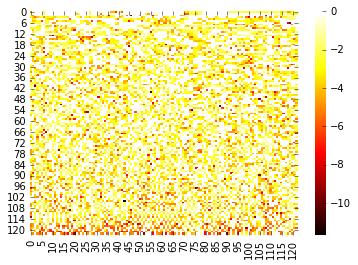

In [46]:
inv_pca = PCA()
pca_data = inv_pca.fit_transform(train_norm_data)

feature_importance = np.nan_to_num(np.log(inv_pca.inverse_transform(np.eye(train_norm_data.shape[1]))))

import seaborn as sns
sns.heatmap(feature_importance, cmap="hot", cbar=True)

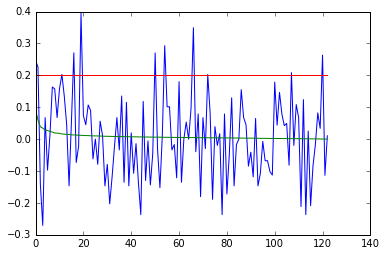

In [54]:
means = np.mean(pca_data, axis=0)/np.sum(np.mean(pca_data, axis=0))
variances = np.var(pca_data, axis=0)/np.sum(np.var(pca_data, axis=0))
xs = [x for x in range(train_norm_data.shape[1])]
threshold = [0.2 for x in xs]
plt.plot(xs, means)
plt.plot(xs, variances)
plt.plot(xs, threshold)
plt.show()

## SVM with all features and with carefully selected features

In [58]:
def mse(real, pred):
    return np.mean(np.square(real-pred))

In [114]:
from sklearn.svm import SVR 

svr = SVR()
svr.fit(train_norm_data, train_labels)

preds = svr.predict(normalize_data(val_data))

In [115]:
mse(preds, val_labels)

73.37395659208052

In [116]:
svr.score(normalize_data(val_data), val_labels)

-0.025847163151464292

In [80]:
#random baseline
random_labels = np.random.normal(np.mean(train_labels), np.std(train_labels), len(val_labels))
mse(random_labels, val_labels)

160.23103613510037

In [92]:
#majority baseline
majority_labels = [np.mean(train_labels) for x in range(len(val_labels))]
mse(majority_labels, val_labels)

71.83710478844854

(array([  1.,   5.,  17.,  47.,  75., 128.,  83.,  38.,  15.,   6.]),
 array([-30.813748  , -25.29375309, -19.77375818, -14.25376328,
         -8.73376837,  -3.21377346,   2.30622145,   7.82621635,
         13.34621126,  18.86620617,  24.38620108]),
 <a list of 10 Patch objects>)

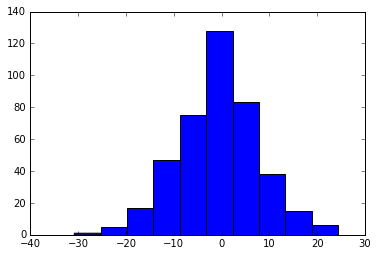

(array([   4.,   21.,   82.,  277.,  605., 1046.,  974.,  530.,  177.,
          23.]), array([-38.78688705, -32.0964598 , -25.40603256, -18.71560531,
        -12.02517807,  -5.33475082,   1.35567642,   8.04610367,
         14.73653091,  21.42695816,  28.1173854 ]), <a list of 10 Patch objects>)

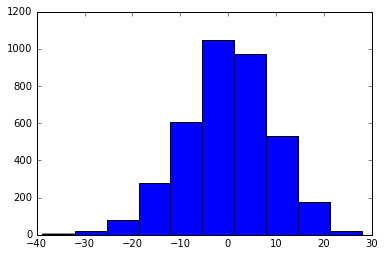